# The Arts meet Data Science - data science course

>“Art is not what you see, but what you make others see.” - Edgar Degas

Written by Ohad Leshno 208938076 , Ofek Deitch 315870840

# Research proposal

## The Goal

###### What is the problem we attempt to solve?


As keen lovers and admirers of the arts, we really wanted to be able to recognize elements in artworks, such as the artist, the year of creation, the technique and even, if possible, the material upon which the painting was painted.

## Motivation

###### Why is this problem important?


There is quite an absence in the accessibility of such insights as we mentioned above. Many people have paintings at their homes, which they received from their parents, yet know almost nothing thereof. What if those paintings were rare? or, perhaps, were worth more than one would allow oneself to throw away unintentionally? Many businesses offer this sort of data at prices so high that it simply becomes impossible to access [see figure below](https://www.artnet.com/price-database/). We wish to prevent these mishappenings, while enabling everyone to take a picture of the paintings in their belongings and to receive an immediate assessment of it.

<img src="pricing.png"  />


Further, an interesting investigation could be to recognize not only who the painter of a painting is, but also to approximate how much that painting is worth. This could also come handy for novice painters who wish to sell their works at a fair price based on their skill and technique. Incidentally, the world known and celebrated artist Banky has played a trick ([link to video](https://www.youtube.com/watch?v=7mxJT2uXtrE&t=39s)) upon random passersby, selling his art at a laughable price of nothing but $60!

His works are sold at prices that oftentimes reach millions. Yet, passersby failed to recognize the artworks on display. Our solution could help by providing a contra-trick, so to speak, and enable everyone to get the chance of recognizing a famous painting and to purchase it at $60 instead of millions.

Another interesting and quite worthwhile investigation could be to create a solution which analyses what makes something beautiful and stand out. A comparison of the greatest paintings of all time could perhaps allow us to do so, and, maybe, even realize how the concept of beauty evolved throughout the centuries and across various countries and continents.

## Data 

Our data is collected from several resources:<br/>Tagged paintings resources: 
* https://www.kaggle.com/ikarus777/best-artworks-of-all-time
* https://www.kaggle.com/c/painter-by-numbers


Another good resouce we found is [arthive.com](https://arthive.com), which contains not only a larger variety of artworks, but also interesting information, such as price, country, year of creation, etc.
* https://arthive.com/artworks/for_sale/type:painting-sort:price-p:6


In the following experiment we will try to showcase a proof of concept (POC) as to whether it is even possible for our neural network to learn to recognize the painter by looking at the painting. We will use the first dataset to train our model.

In [ ]:
from fastai.vision import Path

path = Path("/notebooks/data/best-artworks-of-all-time/images/images")
path.ls()

[PosixPath('/notebooks/data/best-artworks-of-all-time/images/images/.ipynb_checkpoints'),
 PosixPath('/notebooks/data/best-artworks-of-all-time/images/images/Albrecht_Dürer'),
 PosixPath('/notebooks/data/best-artworks-of-all-time/images/images/Alfred_Sisley'),
 PosixPath('/notebooks/data/best-artworks-of-all-time/images/images/Amedeo_Modigliani'),
 PosixPath('/notebooks/data/best-artworks-of-all-time/images/images/Andrei_Rublev'),
 PosixPath('/notebooks/data/best-artworks-of-all-time/images/images/Andy_Warhol'),
 PosixPath('/notebooks/data/best-artworks-of-all-time/images/images/Camille_Pissarro'),
 PosixPath('/notebooks/data/best-artworks-of-all-time/images/images/Caravaggio'),
 PosixPath('/notebooks/data/best-artworks-of-all-time/images/images/Claude_Monet'),
 PosixPath('/notebooks/data/best-artworks-of-all-time/images/images/Diego_Rivera'),
 PosixPath('/notebooks/data/best-artworks-of-all-time/images/images/Diego_Velazquez'),
 PosixPath('/notebooks/data/best-artworks-of-all-time/ima

We will use *fast-ai*'s transforms and normalizer to resize our dataset and prevent over-fitting by adding "dirt". We will set aside a randomly chosen set of 20% of the pictures - that will be our validation group.

In [ ]:
from fastai.vision import ImageDataBunch,get_transforms,imagenet_stats,np

tfms = get_transforms(do_flip=False)
np.random.seed(42)
data = ImageDataBunch.from_folder(path,valid_pct=0.2, ds_tfms=tfms, size=224).normalize(imagenet_stats)

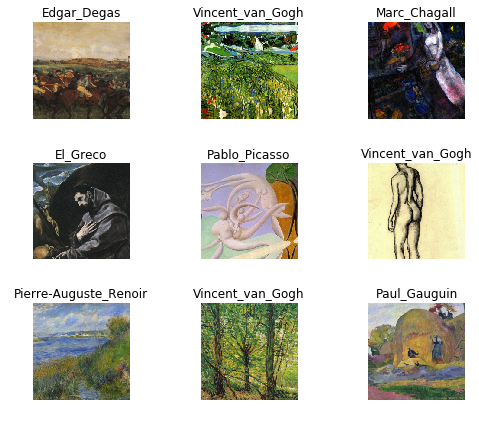

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

Following is the list of artist whose artworks we will attempt to recognize:

In [ ]:
print(data.classes)

['Albrecht_Dürer', 'Alfred_Sisley', 'Amedeo_Modigliani', 'Andrei_Rublev', 'Andy_Warhol', 'Camille_Pissarro', 'Caravaggio', 'Claude_Monet', 'Diego_Rivera', 'Diego_Velazquez', 'Edgar_Degas', 'Edouard_Manet', 'Edvard_Munch', 'El_Greco', 'Eugene_Delacroix', 'Francisco_Goya', 'Frida_Kahlo', 'Georges_Seurat', 'Giotto_di_Bondone', 'Gustav_Klimt', 'Gustave_Courbet', 'Henri_Matisse', 'Henri_Rousseau', 'Henri_de_Toulouse-Lautrec', 'Hieronymus_Bosch', 'Jackson_Pollock', 'Jan_van_Eyck', 'Joan_Miro', 'Kazimir_Malevich', 'Leonardo_da_Vinci', 'Marc_Chagall', 'Michelangelo', 'Mikhail_Vrubel', 'Pablo_Picasso', 'Paul_Cezanne', 'Paul_Gauguin', 'Paul_Klee', 'Peter_Paul_Rubens', 'Pierre-Auguste_Renoir', 'Piet_Mondrian', 'Pieter_Bruegel', 'Raphael', 'Rembrandt', 'Rene_Magritte', 'Salvador_Dali', 'Sandro_Botticelli', 'Titian', 'Vasiliy_Kandinskiy', 'Vincent_van_Gogh', 'William_Turner']


### POC 

#### Training with resnet34 on convolutional neural network 

We used a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. We trained for 8 epochs (4 cycles through all our data). Let's find out how our model reacts:

In [ ]:
from fastai.vision import cnn_learner,error_rate,models
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(8)

In [ ]:
learn.save('b-stage-1')

#### Unfreezing, fine-tuning, and learning rates

Since our model is working as expected, we will *unfreeze* our model and train some more. Meaning we will now unlearn our previous knowledge, and start learning all layers from scratch. We will use *fast-ai*'s `lr_find` function to find the best learning rate.

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


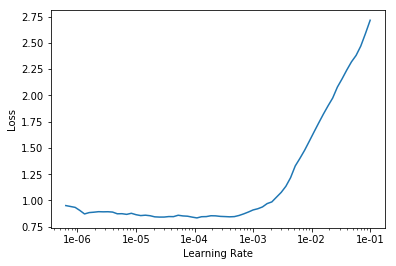

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4,max_lr=slice((1e-5)/2,(1e-3)/2))

In [ ]:
learn.save('a-stage-2')

### Results

As can seen above, we have achieved a success rate of almost 78%! A great start indeed at classifying the right artist. This is just the start. Let's try to improve it. First, let's observe which categories are those which our model is most confused about. This will tell us whether what the model predicted was reasonable or not.

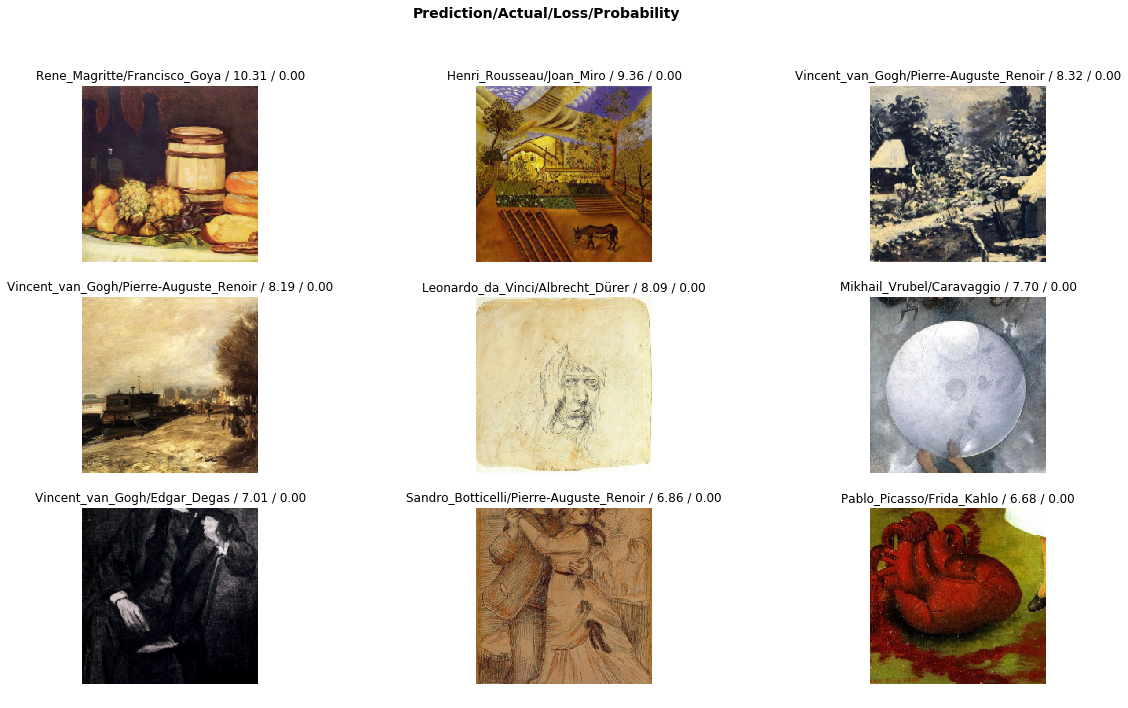

In [ ]:
from fastai.vision import ClassificationInterpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(20,11))

When we look at the <i>confusion matrix</i>, we see that the distribution is heavily skewed: the model makes the same mistakes over and over again, but rarely confuses other categories.

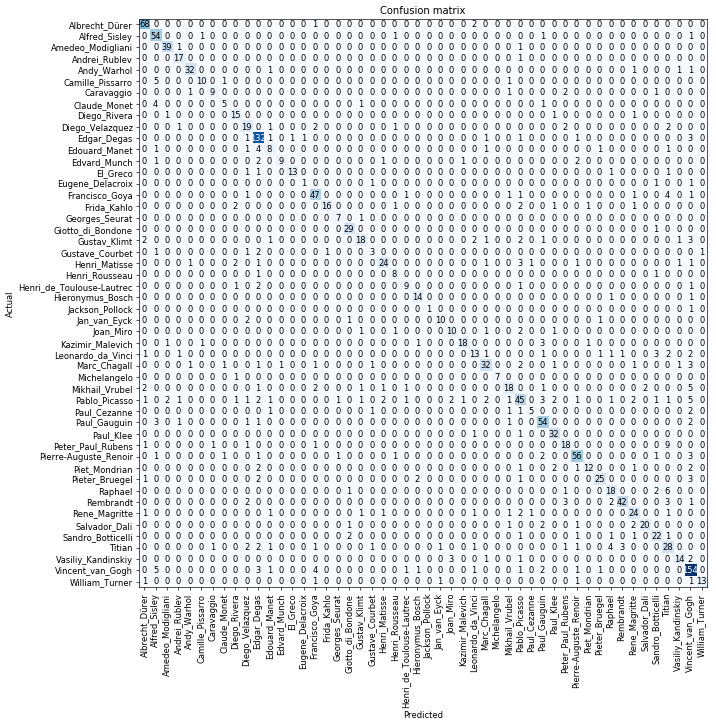

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[('Peter_Paul_Rubens', 'Titian', 9),
 ('Raphael', 'Titian', 6),
 ('Camille_Pissarro', 'Alfred_Sisley', 5),
 ('Mikhail_Vrubel', 'Vincent_van_Gogh', 5),
 ('Pablo_Picasso', 'Vincent_van_Gogh', 5),
 ('Vincent_van_Gogh', 'Alfred_Sisley', 5),
 ('Claude_Monet', 'Alfred_Sisley', 4),
 ('Edouard_Manet', 'Edgar_Degas', 4),
 ('Francisco_Goya', 'Titian', 4),
 ('Titian', 'Raphael', 4),
 ('Vincent_van_Gogh', 'Francisco_Goya', 4),
 ('Edgar_Degas', 'Vincent_van_Gogh', 3),
 ('Gustav_Klimt', 'Vincent_van_Gogh', 3),
 ('Henri_Matisse', 'Pablo_Picasso', 3),
 ('Kazimir_Malevich', 'Paul_Gauguin', 3),
 ('Leonardo_da_Vinci', 'Sandro_Botticelli', 3),
 ('Marc_Chagall', 'Vincent_van_Gogh', 3),
 ('Pablo_Picasso', 'Paul_Gauguin', 3),
 ('Paul_Gauguin', 'Alfred_Sisley', 3),
 ('Pierre-Auguste_Renoir', 'Vincent_van_Gogh', 3),
 ('Pieter_Bruegel', 'Vincent_van_Gogh', 3),
 ('Rembrandt', 'Peter_Paul_Rubens', 3),
 ('Rembrandt', 'Titian', 3),
 ('Titian', 'Rembrandt', 3),
 ('Vasiliy_Kandinskiy', 'Joan_Miro', 3),
 ('Vincent_van

It is quite interesting that a couple of painters most confused are in fact Pablo Picasso and Vincent van Gogh, two artists which use a rather different technique. We will attempt to further investigate this issue and try to identify why this happens.

## What's next?

* Create a multi-label classification of each picture, as mentioned above.
* Improve our neural network by using different images in various sizes.
* Scrape more websites and attempt to implement a regression algorithm with `scikitlearn` and try to see what will excel if there is one.
* Applying our network on photos of framed artworks taken with a standard camera and predict its price

# Results

## Gathering the data


Our primary data source in the following research was [arthive.com](https://arthive.com/), which, other than offering just a larger variety of artworks, offers supplementary information of the showcased artwork: price, country, year of creation and more.

<br/>
 
---

<br/>
 
Arthive does not expose an official API, thus one cannot easily download neither the showcased artworks nor their metadata. We developed, therefore, a dedicated data-scraper for the automated gathering of arthive’s artworks:

We used [Node.js](https://nodejs.org/) along with the [Puppeteer](https://github.com/puppeteer/puppeteer) framework, while simulating real user interactions on the arthive website. The data-scraper went through all of arthive’s priced artworks and downloaded their images and metadata.

The data-scraper’s code can be found [here](https://github.com/ohadleshno/arthive-scrapper). The two main files there are `index.js` and `scrapeSite.js`. The former is responsible for the gathering of all the URLs of pages which contain priced artworks; its output is the `links` file. Once all the links have been successfully gathered, `scrapeSite.js` is used for consuming the various links and for downloading the image files and their corresponding metadata. We have uploaded the final output to Google Drive.

**Why did we use this data-set?**

We chose to use this data-set - and not the ones available on Kaggle - because we had a sense that the most famous artworks are not priced so high for their beauty (even though they are, indeed, beautiful), but for the social status they endow to any one who has them in one’s own private collection.

Using the data-set collected from arthive allows us therefore to investigate whether the price of a piece of art has any correlation with how beauteous it is.


Below is a screen shot taken from the arthive website:
![arthive](https://i.ibb.co/HHkL8VD/Screen-Shot-2020-07-10-at-13-51-09.png)

### The data

In [1]:
# connecting to google drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [2]:
# parsing the data to json then convert it to dataframe

import pandas as pd
import json

with open(root_dir+ 'arthive/imagesInfo.json') as jsonfile:
    parsed = json.load(jsonfile)

df = pd.json_normalize(parsed)
df['price'] =  pd.to_numeric(df['price'].str.replace(r',', ''), errors='coerce')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14463 entries, 0 to 14462
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   workName                          14463 non-null  object 
 1   artistName                        14463 non-null  object 
 2   price                             14457 non-null  float64
 3   imageLink                         14463 non-null  object 
 4   path                              14463 non-null  object 
 5   properties.Art form:              14463 non-null  object 
 6   properties.Style of art:          8903 non-null   object 
 7   properties.Technique:             10053 non-null  object 
 8   properties.Materials:             10557 non-null  object 
 9   properties.Date of creation       11937 non-null  object 
 10  properties.Size                   13297 non-null  object 
 11  properties.Subject and objects:   9166 non-null   object 
dtypes: f

workName  ...                  properties.Subject and objects: 
0                   Path-of-the-heart-Another-world  ...                                               NaN
1                                  Sunny-still-life  ...                                        Still life
2                                           Selfies  ...  Portrait Architecture Fantasy Mythological scene
3                                            Rhodes  ...                                         Landscape
4  Rain-on-the-Cross-Oil-on-canvas-275-x-36-cm-2018  ...                         Landscape Urban landscape

[5 rows x 12 columns]

In [ ]:
df.columns

Index(['workName', 'artistName', 'price', 'imageLink', 'path',
       'properties.Art form: ', 'properties.Style of art: ',
       'properties.Technique: ', 'properties.Materials: ',
       'properties.Date of creation', 'properties.Size',
       'properties.Subject and objects: '],
      dtype='object')

## Finding The Year of Creation

### Finding the decade

In [68]:
!pip install dateparser
import dateparser

year_df = df.copy()

#parse date
year_df = year_df.rename(columns={"properties.Date of creation":"raw_date"})
year_df = year_df[year_df['raw_date'].notna()]
year_df['date'] = year_df['raw_date'].apply(lambda x: dateparser.parse(x))
year_df = year_df[year_df['date'].notna()]
year_df['year'] = year_df['date'].apply(lambda d: d.year)
#round date
year_df['round_year'] = year_df['year'].apply(lambda y: round(y / 10) * 10)




Take a look at the plot below. Notice that most artworks were created after the year 2000. We will try to create a data-set as balanced as is  possible with the data we have collected from arthive, thus we will only try to predict the year of creation of artworks created between 1960 and the present year of writing this document, 2020.

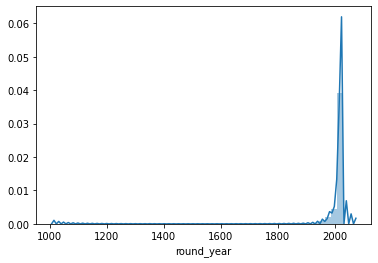

In [ ]:
import seaborn as sns
sns.distplot(year_df.round_year)

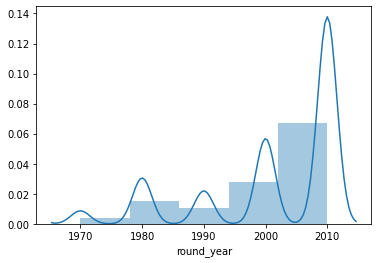

In [ ]:
sns.distplot(year_df[(year_df.round_year >=1970) & (year_df.round_year <= 2020)].round_year,bins=5)

In [ ]:
year_df.round_year.value_counts()

2020    7203
2010    1799
2000     738
1980     397
1990     286
1960     135
1970     112
1950      59
1940      39
1930      21
1920      16
2030      16
1910      10
1900      10
1860       4
1880       2
1560       2
1890       2
1850       1
1010       1
2050       1
1350       1
1790       1
1840       1
1760       1
2070       1
Name: round_year, dtype: int64

In [69]:
#delete with not enough data
year_df = (
  year_df[(year_df['round_year'] >= 1960) & (year_df['round_year'] <= 2020)]
    [['path', 'round_year']]
    .rename(columns={"round_year":"year"})
) 
year_df.head(1)

path  year
5  images/Agnessa-Morkovina--Two-bouquets--5.webp  2010

#### Training with neureal network over resnet model

The ResNet (Residual Neural Network) stemmed from the hypothesis that “deeper is better”, meaning more layers should result in a “smarter” network, that in turn could handle a wider range of concepts. This, although, turned out to be not so true, since research has shown that adding too many layers eventually degrades results.

**Why did this happen?**<br/>
A widespread hypothesis was assumed, that the identity function is to be learned by the network, and so, given a highly trained network with depth of n, a deeper network – say, with a depth of n + k – could achieve the same results by having n layers with the same weights as the former network and k layers which implement the identity function. The deeper network could thus achieve results that are at least as good as any shallow network.

This, quite contrary to the belief of the community, turned out to be erroneous, since the identity function was actually not an elementary function to learn.

Yet, ResNet suggests a solution for overcoming this problem: adding so-called “shortcuts” between layers; these shortcuts could be double or triple, thus skipping one, two or even three layers at a time.

**Why skip layers?**<br/>
Skipping layers simplifies the network, making the learning process quicker. Weights are laid not just for the neurons, but also for the skipping of layers. Thus, as the learning process advances, weights could be adjusted to skip more layers or less layers where needed, thereby adding more complexity to curtain areas (or features) of the network, while maintaining simplicity at others.


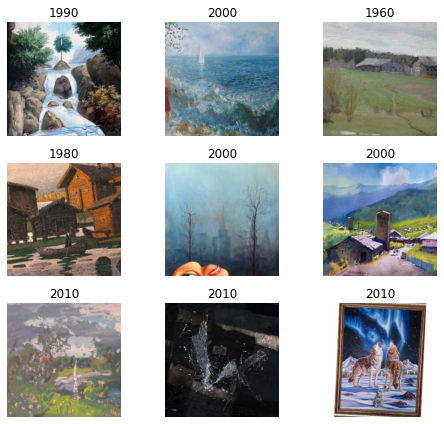

In [70]:
from fastai.vision import get_transforms,Path , ImageList ,imagenet_stats


tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0)
data_bunch = (ImageList.from_df(year_df, Path(root_dir + '/arthive'))
        .split_by_rand_pct()
        .label_from_df(cols='year')
        .transform(tfms, size=224)
        .databunch()).normalize(imagenet_stats)
data_bunch.show_batch(rows=3, figsize=(7,6))

In [8]:
from fastai.vision import models,cnn_learner,ShowGraph
from fastai.metrics import accuracy
learn = cnn_learner(data_bunch, models.resnet50,metrics=accuracy, callback_fns=[ShowGraph])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


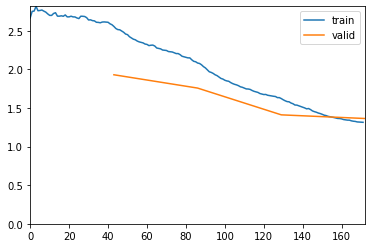

In [ ]:
from fastai.vision import models,cnn_learner,ShowGraph
from fastai.metrics import accuracy
learn = cnn_learner(data_bunch, models.resnet50,metrics=accuracy, callback_fns=[ShowGraph])
lr = 1e-3
learn.fit_one_cycle(4, lr)
learn.save("decade-of-creation-stage1")

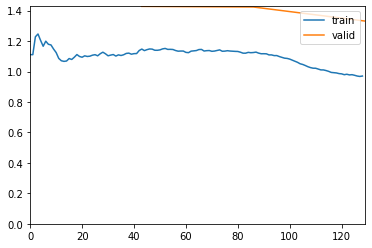

In [ ]:
learn.fit_one_cycle(3, lr)


In [ ]:
learn.save("decade-of-creation-stage1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


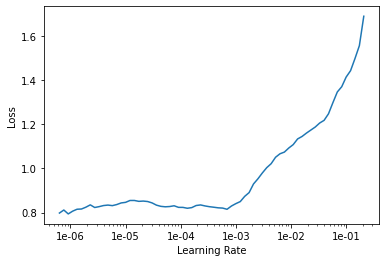

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

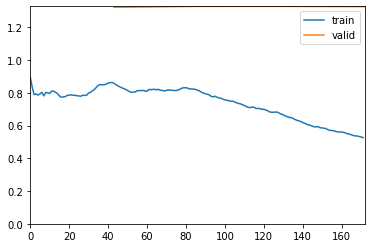

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-5, (1e-3)/2))

In [ ]:
learn.save("decade-of-creation-stage2")

### Regression Model over ResNet

In [10]:
!pip install dateparser
import dateparser

year_df = df.copy()

#parse date
year_df = year_df.rename(columns={"properties.Date of creation":"raw_date"})
year_df = year_df[year_df['raw_date'].notna()]
year_df['date'] = year_df['raw_date'].apply(lambda x: dateparser.parse(x))
year_df = year_df[year_df['date'].notna()]
year_df['year'] = year_df['date'].apply(lambda d: d.year)

In this method we will try to predict the price of artwork by its image exclusivly. Here we will not to classify to groups by will try to regression to guess accurte price. Therefore the labels in our databunch will be floatList (range of numbers). 

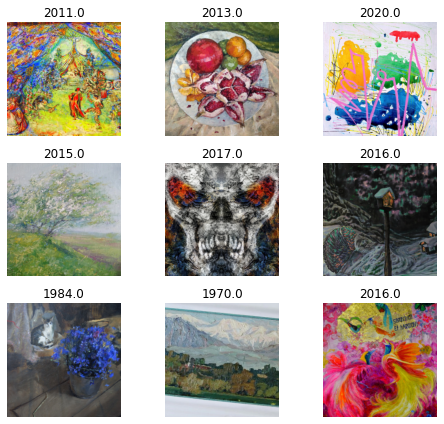

In [11]:
from fastai.vision import get_transforms,Path , ImageList ,imagenet_stats,FloatList

year_df = (
  year_df[(year_df['year'] >= 1970) & (year_df['year'] <= 2020)]
    [['path', 'year']]
).dropna() 

tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0)
data_bunch = (ImageList.from_df(year_df, Path(root_dir + '/arthive'))
        .split_by_rand_pct()
        .label_from_df(cols='year', label_cls=FloatList)
        .transform(tfms, size=224)
        .databunch()).normalize(imagenet_stats)
data_bunch.show_batch(rows=3, figsize=(7,6))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-01
Min loss divided by 10: 3.31E-01


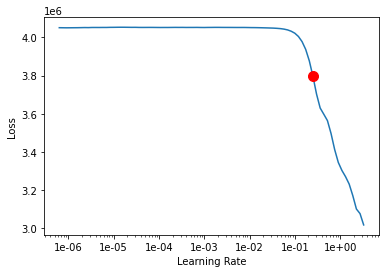

In [ ]:
from fastai.vision import models,cnn_learner
from fastai.metrics import root_mean_squared_error


learn = cnn_learner(data_bunch, models.resnet34,metrics=[root_mean_squared_error])
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [14]:
lr = 2.51e-01
learn.fit_one_cycle(2, lr)
learn.save('year-linear-resnet34-1')
learn.load('year-linear-resnet34-1')

In [ ]:
learn.save('price-year')

### Discussion

If we look at the "Confusion Matrix" below, we can see that the darker areas are in the bottom-right corner, meaning that the model predicted that most of the artworks are from later decades, e.g. 2010, 2020.

When thinking about it, we realized that this was, in fact, a result of an imbalanced distribution of data-itmes through the different categories. The decade of 2020 has had a tremendously larger cut of the total data-set, when compared to the other categories. Thus, the bias of our model becomes quite understandable. Naturally, another reason could be that there is simply not enough correlation between the artworks and the year in which they were created. That is, of course, not true when considering artwork from different epochs in history: it is quite easy to distinguish between a painting from the Rococo era and a painting from the Impressionism era, as you can see in the two images below. Thus, perhaps our largest problem here was actually an imbalanced data-set.

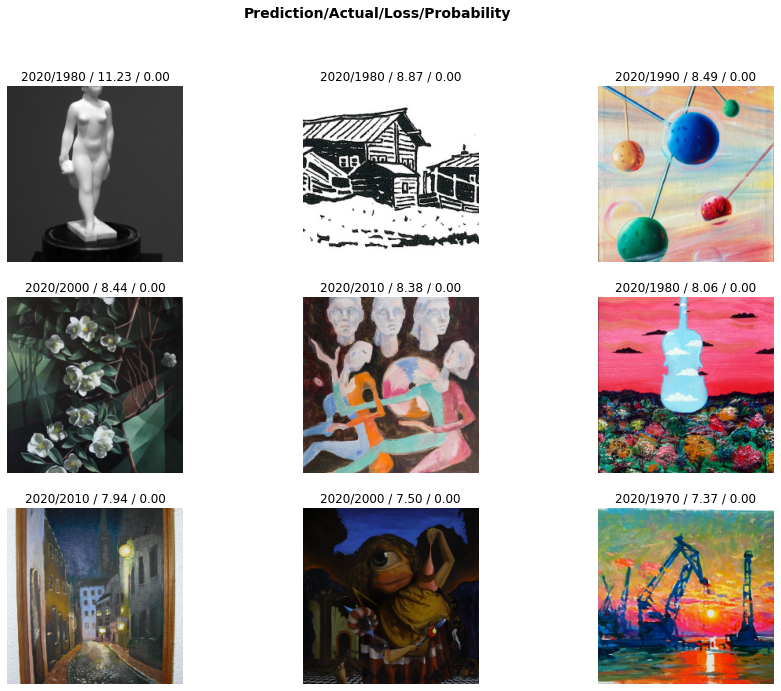

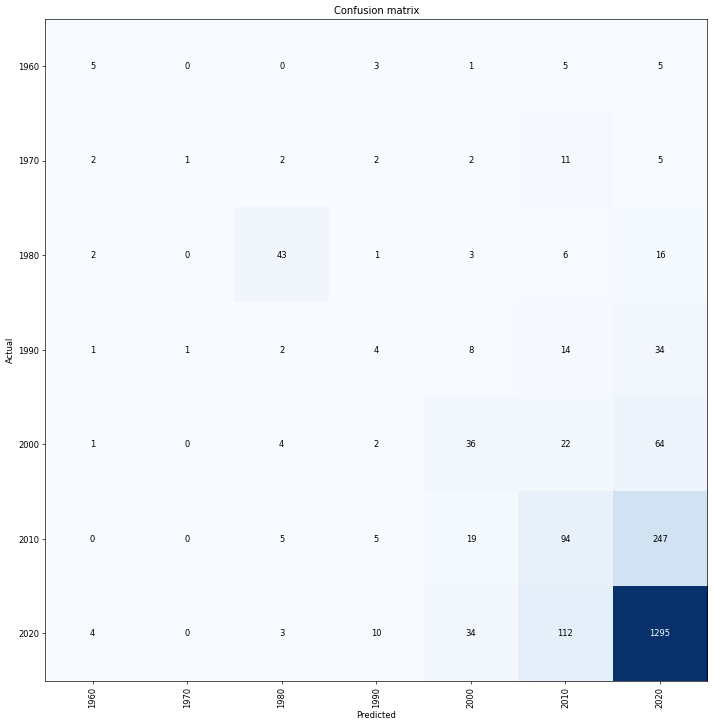

In [ ]:
from fastai.vision import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Naturally, another reason could be that there is simply not enough correlation between the artworks and the year in which they were created. That is, of course, not true when considering artwork from different epochs in history: it is quite easy to distinguish between a painting from the Rococo era and a painting from the Impressionist era, as you can see in the two images below. Thus, perhaps our largest problem here was actually an imbalanced data-set.
 <br/><br/>
A painting from the Rococo era:<br/>
 ![alt text](https://d7hftxdivxxvm.cloudfront.net/?resize_to=width&src=https%3A%2F%2Fartsy-media-uploads.s3.amazonaws.com%2FKfZoFu7UmYpM8zxCZSq5VA%252FDeclarationoflove.jpg&width=1200&quality=80)
 <br/>*Jean-François de Troy, The Declaration of Love (1731)*
 <br/><br/>
A painting from the Impressionist era:<br/>
![alt text](https://www.christies.com/img/LotImages/2017/NYR/2017_NYR_15004_0017A_000(camille_pissarro_jardin_de_kew_londres_pres_dun_etang).jpg)
*Camille Pissarro (1830-1903), Jardin de Kew, Londres, près d'un étang*


## Multi Class Identification of Style of Art

### Cleaning the data

Initially, we shall extract and clean the data a little:

In [ ]:
style_of_art_df = df.copy()
style_of_art_df = style_of_art_df.rename(columns={"properties.Style of art: ":"style"})[['path','style']]
style_of_art_df = style_of_art_df[style_of_art_df['style'].notna()]

#remove strings that are not valid that appear on the style of art
style_of_art_df['style'] = style_of_art_df['style'].str.replace(r'(', '').replace(r')', '').replace(r'The', '').replace(r'author\'s', '').replace(r'style', '').replace(r'Art Nouveau','Art-Nouveau')

#taking art style that appear more than 50 times
style_col = style_of_art_df.groupby("style")["style"].transform(len)
mask = (style_col > 50)
style_of_art_df = style_of_art_df[mask]

style_of_art_df.head(5)

path                              style
0  images/Anastasiia-Mills--Path-of-the-heart-Ano...                        Art-Nouveau
1  images/Anastasia-Karaseva--Sunny-still-life--1...                            Realism
2             images/Alexey-Chernov--Selfies--2.webp                         Surrealism
3         images/Anastasia-Bayandina--Rhodes--3.webp              Impressionism Realism
4  images/Alexander-Victorovich-Shevelyov--Rain-o...  Impressionism Realism Romanticism

We use here the same technique we used before, but now we are trying to achieve multi-class idendifictaion. Thus, each image will have several labels that will be splited by space.


['Abstractionism',
 'Art',
 'Art-Nouveau',
 'Classicism',
 'Expressionism',
 'Impressionism',
 'Nouveau',
 'Realism',
 'Romanticism',
 'Surrealism',
 'Symbolism']

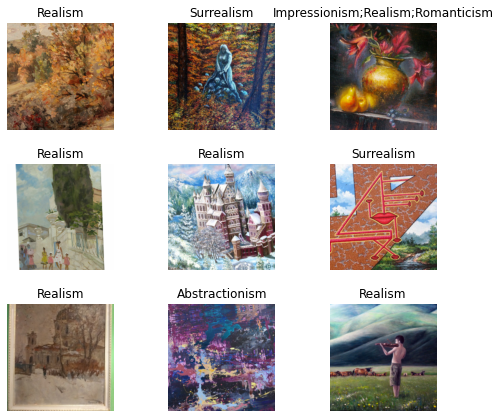

In [ ]:
from fastai.vision import get_transforms,Path , ImageList ,imagenet_stats

tfms = get_transforms(flip_vert=False,do_flip=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data_bunch = (ImageList.from_df(style_of_art_df, Path(root_dir + '/arthive'))
        .split_by_rand_pct()
        .label_from_df(cols='style', label_delim=' ')
        .transform(tfms, size=224)
        .databunch()).normalize(imagenet_stats)
data_bunch.show_batch(rows=3, figsize=(7,6))
data_bunch.classes

Since we are using multi-class classfication here, we need a diffrent scoring method than the one we used before. In the following section, we shall use the F-Beta score and accuracy thresh. 

Accuracy thresh computes accuracy when y_pred and y_true are the same size.
Predictions are compared to thresh after a sigmoid function is applied. Then we count the numbers that match the targets.

F_beta is calculated by the following equation:
$${F_\beta} = (1+\beta^2)\frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall}$$ 
We shall use the default value of Beta = 2.






Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 2.51E-02


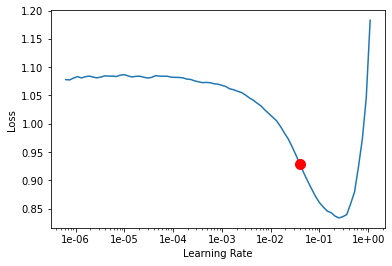

In [ ]:
from fastai.vision import models,cnn_learner ,partial,ShowGraph
from fastai.metrics import fbeta,accuracy_thresh
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data_bunch, models.resnet34,metrics=[f_score, acc_02], callback_fns=[ShowGraph])
learn.lr_find()
learn.recorder.plot(suggestion = True)


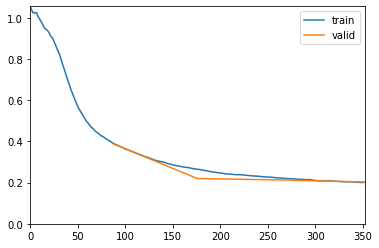

In [ ]:
lr = 3.31E-02
learn.fit_one_cycle(4, lr)
learn.save("mutli-class-style-stage1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 1.32E-05


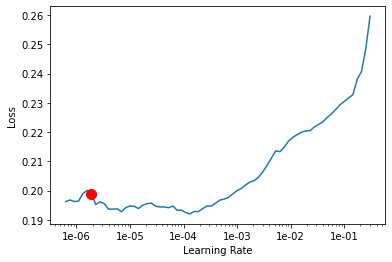

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)


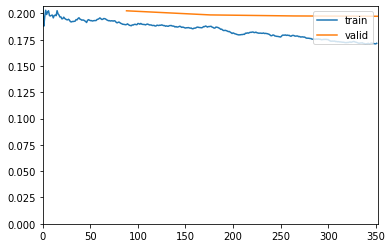

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-5, 1e-4))
learn.save("mutli-class-style-stage2")

### Discussion

An accuracy of almost 90% is a result we are quite content with. It’s not surprising that we were indeed able to achieve such results, since--as even a trained neural network can tell us--there is a connection between a style of art and the visual appearance of the works categorized under these style-categories.

## Predicting price range

In [15]:
price_df = df.copy()
price_df = price_df[price_df.price.notna()]

### Selecting a better range of prices

In the following section, we gathered it might be wiser to train our model with a data-set that is more balanced. As we have seen in the attempt to predict the year of creation, an imbalanced data-set can degrade the results, and create a bias towards the class with the largest set of data.

Therefore, as can be seen in the following cells, we plotted the distribution of prices, and it turns out that most artworks are priced below 200 USD.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


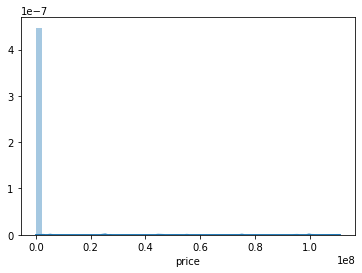

In [ ]:
import seaborn as sns

sns.distplot(price_df['price'])

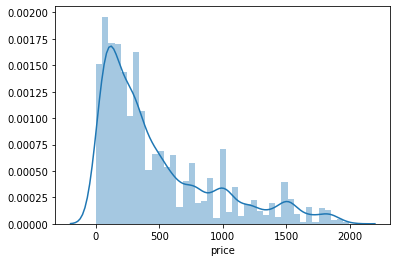

In [ ]:
price_range = price_df[(price_df['price'] > 0) & (price_df['price'] < 2000)]['price']
sns.distplot(price_range)

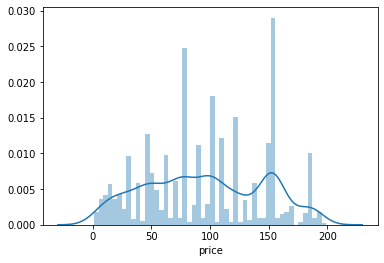

In [ ]:
price_range = price_df[(price_df['price'] > 0)& (price_df['price'] < 200)]['price']
sns.distplot(price_range,bins=50)

In [16]:
price_df = price_df[(price_df.price > 0) & (price_df.price <200 )] 

### First try - only using the image of artwork

In this method we will try to predict the price of artwork by its image exclusivly. Here we will not to classify to groups by will try to regression to guess accurte price. Therefore the labels in our databunch will be floatList (range of numbers). 

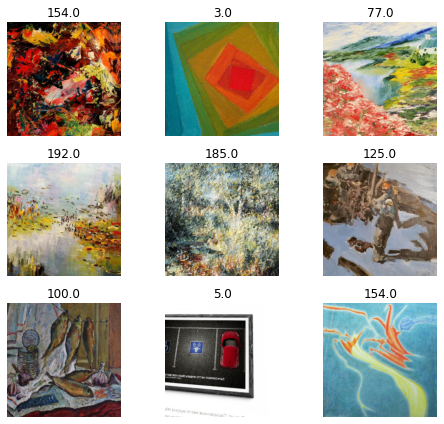

In [51]:
from fastai.vision import get_transforms,Path , ImageList ,imagenet_stats,FloatList

tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

data_bunch = (ImageList.from_df(price_df[['path','price']], Path(root_dir + '/arthive'))
        .split_by_rand_pct(0.2)
         .label_from_df(cols='price', label_cls=FloatList)
        .transform(get_transforms(), size=224)
        .databunch(bs=16)).normalize(imagenet_stats)
        
data_bunch.show_batch(rows=3, figsize=(7,6))

#### using resnet 34 as is

we take resnet modal as is but changing to loss function from  mean absolute error to be L1loss 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 1.32E-01


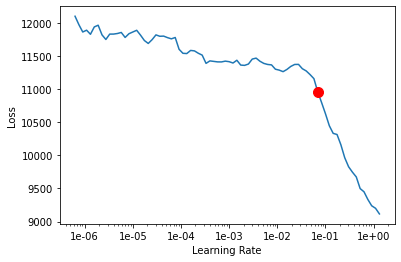

In [ ]:
from fastai.vision import models,cnn_learner
from fastai.metrics import root_mean_squared_error


learn = cnn_learner(data_bunch, models.resnet34,metrics=[root_mean_squared_error])
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [ ]:
lr =6.92E-02
learn.fit_one_cycle(3,lr)
learn.save('price-resnet34-stage1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


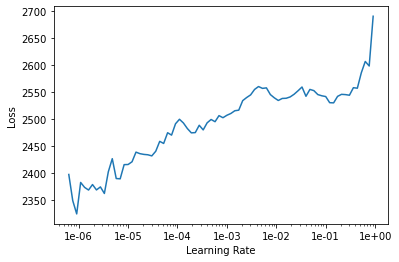

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2,max_lr=slice(1e-5,1e-4))
learn.save('price-resnet34-stage2')

#### using resnet 50 


Here we tried to get a better results using a diffrent model, [resent50] (https://cv-tricks.com/keras/understand-implement-resnets/) which built a little bit diffrently and sometimes get better results.

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 1.32E-01


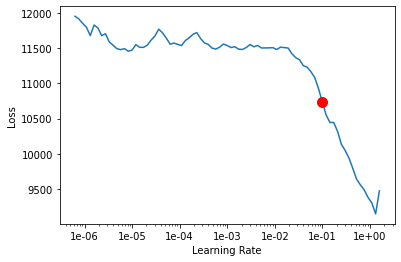

In [ ]:
from fastai.vision import models,cnn_learner
from fastai.metrics import fbeta,root_mean_squared_error

learn = cnn_learner(data_bunch, models.resnet50,metrics=[root_mean_squared_error])
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [ ]:
lr =0.1
learn.fit_one_cycle(5,lr)
learn.save('price-resnet50-f1loss-stage1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


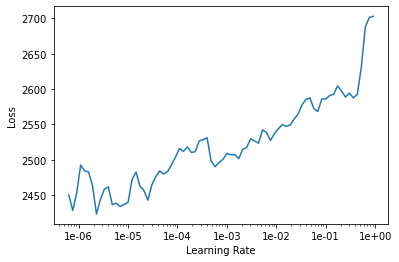

In [ ]:
learn.save('price-resnet50-f1loss-stage1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()


In [ ]:
learn.fit_one_cycle(2,max_lr=slice(1e-5,1e-4))
learn.save('price-resnet50-f1loss-stage2')

#### Building a model over resnet

To be able to achieve it we found a model that built over the model of resnet 34.

The model takes the basic resnet34 model cuts his two last layers and add more layers to acomplish a better regression model. The first layer that been added is a pooling layer its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network. Pooling layer operates on each feature map independently. Then the next layer flatten it the range of dims into a tensor. Afterwords the BatchNorm normaliz.We have then a couple of linear layers and dropout layer to prevent from Overfitting. The last layer is of course a linear layer and the second parameter represnts the number of outputs that should be one. We use the default optimizer admam with diffrent settings and diffrent loss function also.
L1 Smooth Loss was used which behaves better than L1 or L2 losses in our case.

In [52]:
from fastai.vision import nn,cnn_learner,models,Tensor,Rank0Tensor,Flatten,AdaptiveConcatPool2d  

class PriceModal(nn.Module):
  def __init__(self):
    super().__init__()
    layers = list(models.resnet34(pretrained=True).children())[:-2]
    layers += [AdaptiveConcatPool2d(), Flatten()]
    layers += [nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
    layers += [nn.Dropout(p=0.50)]
    layers += [nn.Linear(1024, 512, bias=True), nn.ReLU(inplace=True)]
    layers += [nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
    layers += [nn.Dropout(p=0.50)]
    layers += [nn.Linear(512, 16, bias=True), nn.ReLU(inplace=True)]
    layers += [nn.Linear(16,1)]
    self.pricemodal = nn.Sequential(*layers)
  def forward(self, x):
    return self.pricemodal(x).squeeze(-1)
        
class L1LossFlat(nn.SmoothL1Loss):
  def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
   return super().forward(input.view(-1), target.view(-1))

In [ ]:
from fastai.vision import nn,Learner,ShowGraph,Tensor,partial,optim,ShowGraph
from fastai.metrics import root_mean_squared_error

opt_func = partial(optim.Adam, betas=(0.9,0.99), eps=1e-5)
model = PriceModal()

learn = Learner(data_bunch, model, model_dir = "/content/gdrive/My Drive/arthive/models/", opt_func=opt_func, bn_wd=False, metrics=root_mean_squared_error,
               callback_fns=[ShowGraph]).mixup(stack_y=False, alpha=0.2)
learn.loss = L1LossFlat()
learn.split([model.pricemodal[4],model.pricemodal[6],model.pricemodal[8]])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 7.59E-02


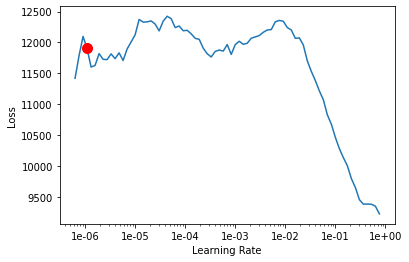

In [54]:
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot(suggestion = True)

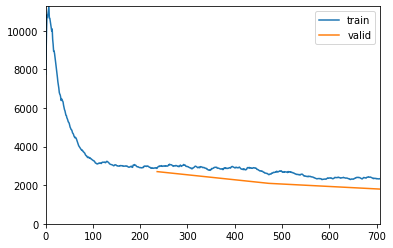

In [56]:
lr = 4E-01
learn.fit_one_cycle(3, max_lr=slice(lr), wd=(1e-6, 1e-4, 1e-2, 1e-1), pct_start=0.5)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E+00
Min loss divided by 10: 1.74E-06


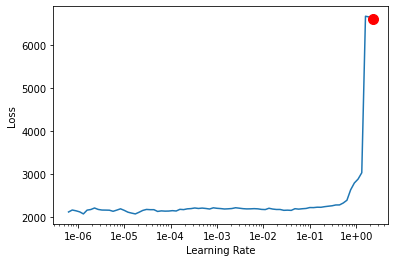

In [57]:
learn.save('price-linear-model-image-1')
learn.load('price-linear-model-image-1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

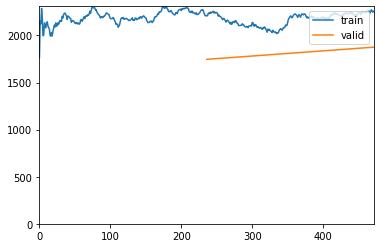

In [59]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4), wd=(1e-6, 1e-4, 1e-2, 1e-1), pct_start=0.5)
learn.save('price-linear-model-image-2')

##### image resizing

We have used Image Resizing technique in which image sizes were gradually increased which sometimes helpes in getting higher accuracy, but as you can see it didn't help. 

In [64]:
resize_data_bunch = (ImageList.from_df(price_df[['path','price']], Path(root_dir + '/arthive'))
        .split_by_rand_pct(0.2)
        .label_from_df(cols='price', label_cls=FloatList)
        .transform(get_transforms(), size=512)
        .databunch(bs=16)).normalize(imagenet_stats)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.02E-06


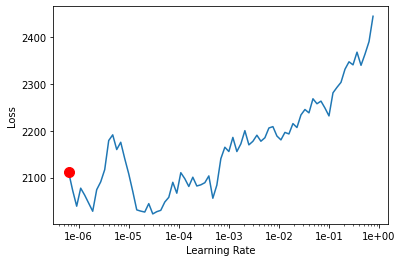

In [61]:
learn.data = resize_data_bunch
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot(suggestion = True)

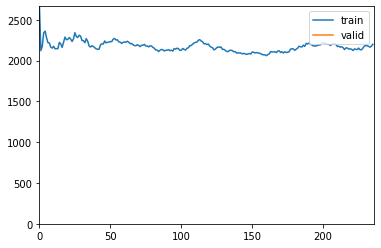

In [66]:
learn.fit_one_cycle(1, max_lr=slice(6.31E-07), wd=(1e-6, 1e-4, 1e-2, 1e-1), pct_start=0.5)
learn.save('price-linear-model-image-3')

This graph presents the error margin made by our model ,you can see below the amount of errors that the error margin was smaller then 5 USD .

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(764, 48)

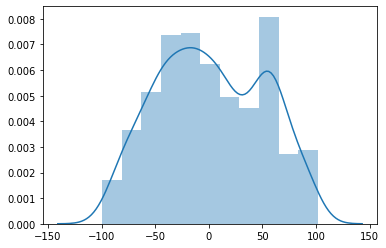

In [63]:
import seaborn as sns
val_preds,val_targets = learn.get_preds()
dif = (val_targets-val_preds)
sns.distplot(dif)
len(dif),len(dif[(dif<5)& (dif>-5)])

### Analysing just the metadata of the artwork to predict price


#### Cleaning the Data

In [78]:
!pip install dateparser
import dateparser


price_tabular_df = price_df.copy()
#parse date
price_tabular_df = price_tabular_df.rename(columns={"properties.Date of creation":"raw_date"})
price_tabular_df = price_tabular_df[price_tabular_df['raw_date'].notna()]
price_tabular_df['date'] = price_tabular_df['raw_date'].apply(lambda x: dateparser.parse(x))
price_tabular_df = price_tabular_df[price_tabular_df['date'].notna()]
price_tabular_df['year'] = price_tabular_df['date'].apply(lambda d: d.year)

#parse size to width and height
price_tabular_df = price_tabular_df[price_tabular_df['properties.Size'].notna()]
price_tabular_df = price_tabular_df[price_tabular_df['properties.Size'].str.contains("×")]

price_tabular_df['width'] = price_tabular_df['properties.Size'].apply(lambda x: float(str(x).split('×')[0]))
price_tabular_df['height'] = price_tabular_df['properties.Size'].apply(lambda x: float(str(x).split('×')[1].split('×')[0].split('cm')[0]))

price_tabular_df.drop(['properties.Size','raw_date','date','path','imageLink'],axis=1,inplace=True)

#### Working with tabularlist 

Tabular data is one of the most widespread forms of data storage in the industry. Every relational database is tabular data, so being able to use a Neural Network on the rows we have in our databases could provide almost every company a giant boost to their ability to be a data-driven company.


But, for many years, using tabular data as input for a neural network has been overlooked; it was quite hard to get good results out of it, when one ventured in doing so. One solution we have learned from the fast.ai library is the [usage of embeddings](https://www.fast.ai/2018/04/29/categorical-embeddings/).

Before diving into what embeddings are, it is important to differentiate between Continuous Variables and Categorical Variables. 

Continuous Variables are numeric variables that can, theoretically, have endless options as to their values. If our tabular data has one million rows, then, theoretically, we could have a million different values in that one column. An example of continuous values in our metadata is the price of the artwork, its size and date of creation. 

Categorical Variables, as implied by their name, are variables that can be treated as categories. Categorical variables, in contrast to continuous variables, usually have a limited amount of options. An example of categorical variables in our metadata is the name of the painter, the style of art, and the technique.

As a side note, FastAI recommends treating years as categorical variables, too. Since there aren’t so many years usually, a neural network can easily handle them this way, which can improve the results slightly.

Back to the concept of embeddings: the idea of embeddings is to add weights to every category within a categorical value column—say, k weights to each category. These weights, at first, could be random, but as the network learns from the tabular data, it would adjust these weights, until, eventually, each weight will correspond to some quality or concept—just like the neurons in our net correspond with the existence of some concept or the lack thereof.


In [79]:
from fastai.tabular import TabularList,Categorify,Normalize,FillMissing,Categorify
dep_var = 'price'
cat_names = ['artistName','workName', 'properties.Style of art: ', 'properties.Technique: ', 'properties.Materials: ','properties.Subject and objects: ','properties.Art form: ']
cont_names = ['year','height','width']
procs = [FillMissing, Categorify, Normalize]

data = (TabularList.from_df(price_tabular_df, path=root_dir+'arthive', cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_rand_pct(0.2)
                           .label_from_df(cols=dep_var,label_cls = FloatList)
                           .databunch())
data.show_batch(rows=10)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


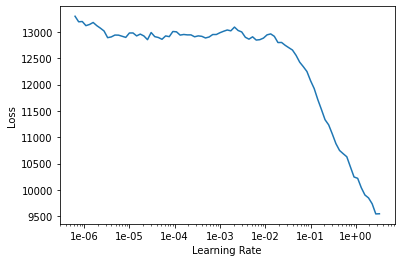

In [80]:
from fastai.tabular import tabular_learner
from fastai.metrics import root_mean_squared_error

learn = tabular_learner(data, layers=[200,100], metrics=root_mean_squared_error)
learn.lr_find()
learn.recorder.plot()

In [81]:
learn.fit(3, 1e-1)

The following graph shows the error margin achieved by our model.
Above the graph, we can see that the number of predictions were 512, 68 of them had an error margin smaller than 5 USD.



(512, 46)

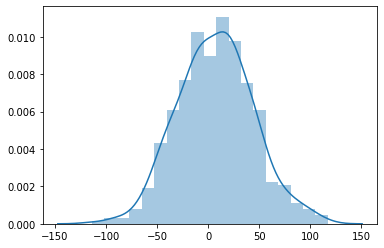

In [82]:
import seaborn as sns
val_preds,val_targets = learn.get_preds()
dif = (val_targets-val_preds.flatten())
sns.distplot(dif)
len(dif),len(dif[(dif<5)& (dif>-5)]) 

#### Using DecisionTreeRegressor

In [83]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn import metrics
import pandas as pd 
from math import sqrt

dummydf = pd.get_dummies(price_tabular_df)
model = DecisionTreeRegressor()
X = dummydf.drop('price',axis=1) # Features
y = dummydf['price'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 70% training and 30% test
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print("Root mean squared error:",sqrt(metrics.mean_squared_error(y_test, y_pred)))


Root mean squared error: 48.299484013241994


This graph presents the error margin made by our model ,you can see below the amount of errors that the erorr margin was smaller then 5 USD.

(513, 133)

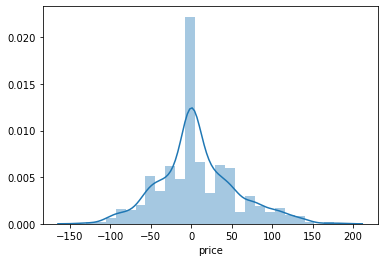

In [84]:
import seaborn as sns
dif = (y_test-y_pred)
sns.distplot(dif)
len(dif),len(dif[(dif<5)& (dif>-5)])

### Discussion

Funny enough, the best predictions were achieved by learning the tabular data, which is nothing but metadata of the actual works of art. This fact is both outstanding and disquietting. It seems that the price of a piece of art is determined almost chiefly by the name of its creator, and not by how beautiful or unique it is. 

This is nevertheless an innate and inseparable quality of the arts, since--as no action can be really understood apart from the motive which prompted it--a piece of art must be considered in the context in which it was created. No matter how frightful a cubist painting by Picasso is, it is impossible to ignore the reason that made Picasso invent this unprecedented style of art--these cubist paintings are, no doubt, as frightful as they are unique. Yet, this is exactly the reason that made Picasso into the artist he ultimately became, however unappreciated he was during his lifetime. Thus, we must conclude that predicting a price merely by how it looks is an almost impossible task, whilst a strong relation between the price of a piece of art and the name signed at the bottom of shall forever continue to exist.


The root absolute mean error seems to be the best (the lowest) when using the tabular list, but, as can be seen once looking at the graphs of error distribution, when using the decision trees the smallest amount of large deviations were achieved. 

The above results are not far from satisfactory for novice practitioners of Deep Learning as ourselves, but certainly not as good as the state of the art. Although we did everything by the book (as far as we could tell) the results are still far from being perfect. We do, however, suspect that choosing the right data-set has an immense impact on the resulting accuracy. We would like to stress, though, that the data-set we used is, after all, comprised by a list of artworks put up for sale, as they were priced by their creators, which are, quite naturally, biased. If we were to learn the prices of the same artworks not as they were priced by their sellers, but as they were eventually sold, we assume we would have achieved much better results; we would have seen a much narrower distribution of pricing errors.

#### Using a Sigmoid function instead of a linear layer

In this attempt to predict the price of a painting merely by its look, we used a linear layer at the end of our model. It is, however, possible and certainly worth to try to place a sigmoid layer at the end of the model, since we do know, prior to making predictions, the range in which the eventual prices should be. After transforming the prediction to a value between zero and one, we would need to multiply it by the difference between the maximum (M) and minimum (m) values, and then add to it the minimum value, as follows:<br/>


<center><i>Prediction(x) = Sigmoid(x) * (M - m) + m</i></center><br />



That being said, it is important to note that a sigmoid function should be used while setting the lower and upper bounds to a trifle more than the maximum value and a trifle lower than the minimum value we expect, since the sigmoid function never reaches the values zero or one--unless the model predicts an extremely large or extremely small value. Thus, when trying this approach while predicting the prices of the artworks, we would set the minimum to -10 and the maximum to 210.


# Summary

As Banksy once said:

> “Art should comfort the disturbed and disturb the comfortable.”
 
There is always more to learn, and there is always a slightly more advanced technique with which better results could be achieved. Nevertheless, we had a really good time while working on this project, and we certainly learned a lot from it. 

It was a pleasure to discover--to affirm, perhaps--that art is almost always dependent on the person regarding it, and that the artwork cannot (and must not) be torn away from the context in which it was created. This is a fundamental part of art, and will always be so.

Thanks for reading.